# <div align="center"> 中餐分类 </div>

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,pandas,matplotlib,sklearn,torch,torchvision

CPython 3.6.9
IPython 7.16.2

numpy 1.19.5
pandas 1.1.5
matplotlib 3.3.4
sklearn 0.24.2
torch 1.11.0.dev20211227+cu111
torchvision 0.12.0.dev20211227+cu111


In [2]:
import pandas as pd  
import argparse      
import shutil        
import os            
import random
import numpy as np
import json

import torch
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from IPython.display import display
from PIL import Image

from torchvision.utils import make_grid

from k12libs.utils.nb_dataset import k12ai_compute_mean_std

In [3]:
K12AI_DATASETS_ROOT = '/data/k12ai/datasets'

In [4]:
dataset = 'rcnfood12'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
imgs_path = os.path.join(data_root, 'imgs')

In [5]:
!ls $imgs_path

023  026  031  033  040  044  124  136	159  167  191  239


In [6]:
cn_labels_maps = {
    '000': '麻婆豆腐',
    '005': '酸辣土豆丝',
    '011': '鱼香茄子',
    '015': '醋溜白菜',
    '017': '手撕包菜',
    '023': '炒豆芽',
    '026': '蚝油西兰花',
    '028': '莲藕',
    '031': '凉拌木耳',
    '033': '花生米',
    '040': '炒苦瓜',
    '044': '松仁玉米',
    '050': '西红柿炒鸡蛋',
    '054': '猪肝',
    '058': '糖醋排骨',
    '060': '可乐鸡翅',
    '075': '啤酒鸭',
    '077': '红烧肉',
    '083': '梅菜扣肉',
    '094': '酱焖猪蹄',
    '101': '蚂蚁上树',
    '103': '羊肉串',
    '106': '酸菜鱼',
    '118': '香辣小龙虾',
    '124': '生蚝',
    '136': '鸡蛋灌饼',
    '144': '馒头',
    '149': '炸酱面',
    '159': '饺子',
    '167': '小米粥',
    '170': '皮蛋瘦肉粥',
    '191': '毛血旺',
    '209': '北京烤鸭',
    '226': '麻花',
    '239': '凉拌皮蛋'
}

## 读取原始数据

In [7]:
labelnames = !ls $imgs_path
name2label = {cn_labels_maps[n]:i for i, n in enumerate(labelnames)}
name2label

{'炒豆芽': 0,
 '蚝油西兰花': 1,
 '凉拌木耳': 2,
 '花生米': 3,
 '炒苦瓜': 4,
 '松仁玉米': 5,
 '生蚝': 6,
 '鸡蛋灌饼': 7,
 '饺子': 8,
 '小米粥': 9,
 '毛血旺': 10,
 '凉拌皮蛋': 11}

In [8]:
label_images = {}

def scan_images(path):
    images = []
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir():
                images.extend(scan_images(entry.path))
            else:
                images.append(entry.path[len(imgs_path)+1:])
    return images

with os.scandir(imgs_path) as it:
    for entry in it:
        if not entry.is_dir():
            continue
        label_images[name2label[cn_labels_maps[entry.name]]] = scan_images(entry.path)
len(label_images), len(label_images[0]), label_images.keys()

(12, 1366, dict_keys([10, 6, 11, 4, 8, 2, 3, 0, 7, 1, 9, 5]))

## 对比

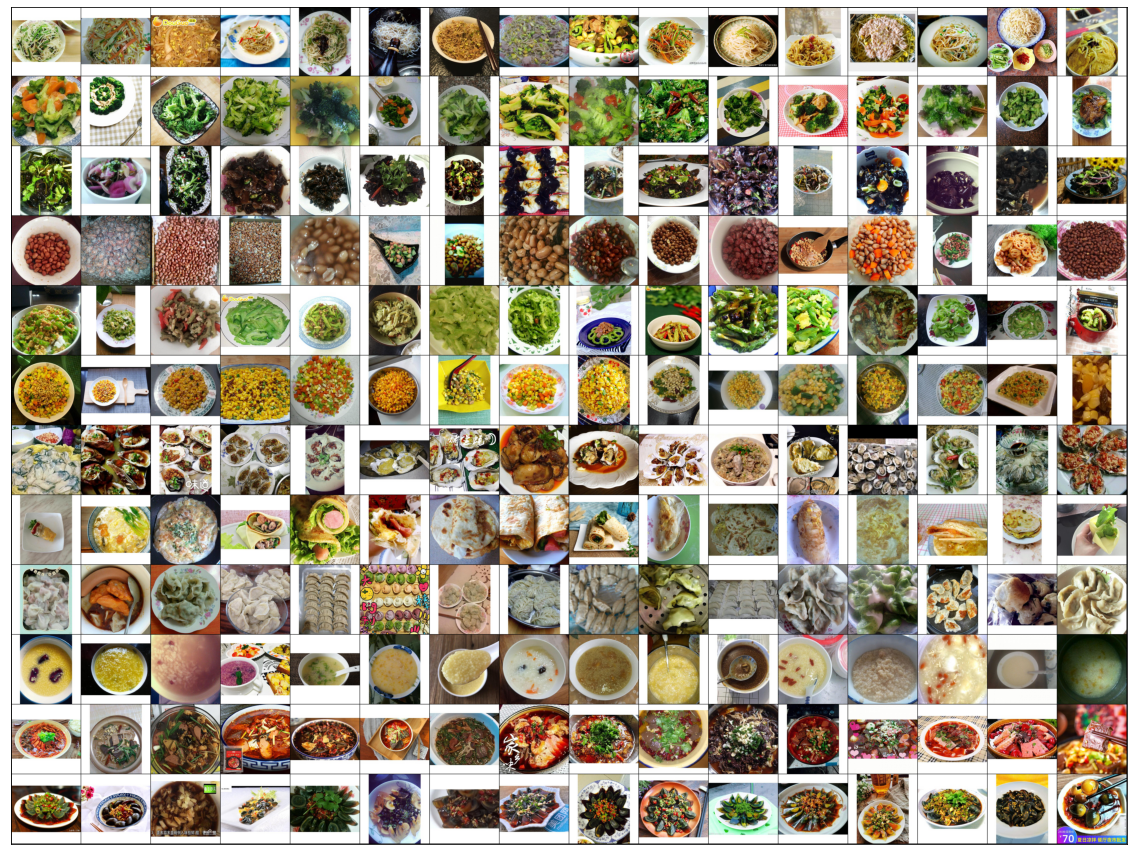

In [9]:
samples = []
sampnum = 16
for label in sorted(list(label_images.keys())):
    for img in label_images[label][:sampnum]:
        samples.append(torch.from_numpy(np.asarray(Image.open(f'{imgs_path}/{img}'))).permute(2, 0, 1))
    
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_xticks([])
ax.set_yticks([])
grid_img = make_grid(samples, nrow=sampnum).permute(1, 2, 0)
ax.imshow(grid_img)

In [10]:
plt.imsave(f'{data_root}/samples_grid.jpg', grid_img.numpy())

## 切割数据集

In [11]:
# 7:2:1 split for train:valid:test dataset
all_images = []
test_images = []
valid_images = []
train_images = []
for label, files in label_images.items():
    for img in files:
        all_images.append((label, img))
        value = random.random()
        if value < 0.1: # test
            test_images.append((label, img))
        elif value < 0.3: # val
            valid_images.append((label, img))
        else: # train
            train_images.append((label, img))
test_count, val_count, train_count = len(test_images), len(valid_images), len(train_images)
test_count, val_count, train_count

(860, 1783, 6007)

## 生成json文件

In [12]:
def generate_json_file(images, phase):
    items = []
    for label, img in images:
        items.append({'image_path': 'imgs/' + img, 'label': int(label)})
        
    random.shuffle(items)

    jsonfile = os.path.join(data_root, f'{phase}.json')
    with open(jsonfile, 'w', encoding='utf-8') as fp:
        json.dump(items, fp, ensure_ascii=False)
    return len(items)
        
# train.json
generate_json_file(train_images, 'train');

# val.json
generate_json_file(valid_images, 'val');

# test.json
generate_json_file(test_images, 'test');

# all.json
generate_json_file(all_images, 'all');

In [13]:
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=data_root, jfiles=jfiles, resize=None)
mean, std

([0.6307, 0.59, 0.5056], [0.2673, 0.2842, 0.3181])

## 生成info.json

In [14]:
label_names = list(name2label.keys())

info = {
    'num_records': test_count + val_count + train_count,
    'num_classes': len(label_names),
    'label_names': label_names,
    'mean': mean,
    'std': std,
}

with open(os.path.join(data_root, 'info.json'), 'w') as fw:
    json.dump(info, fw, ensure_ascii=False, indent=4)
    
info

{'num_records': 8650,
 'num_classes': 12,
 'label_names': ['炒豆芽',
  '蚝油西兰花',
  '凉拌木耳',
  '花生米',
  '炒苦瓜',
  '松仁玉米',
  '生蚝',
  '鸡蛋灌饼',
  '饺子',
  '小米粥',
  '毛血旺',
  '凉拌皮蛋'],
 'mean': [0.6307, 0.59, 0.5056],
 'std': [0.2673, 0.2842, 0.3181]}

## 数据平衡分析

In [15]:
df_train = pd.read_json(os.path.join(data_root, 'train.json'))
df_val = pd.read_json(os.path.join(data_root, 'val.json'))
df_test = pd.read_json(os.path.join(data_root, 'test.json'))

In [16]:
df_train['type'] = 'train'
df_val['type'] = 'val'
df_test['type'] = 'test'
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

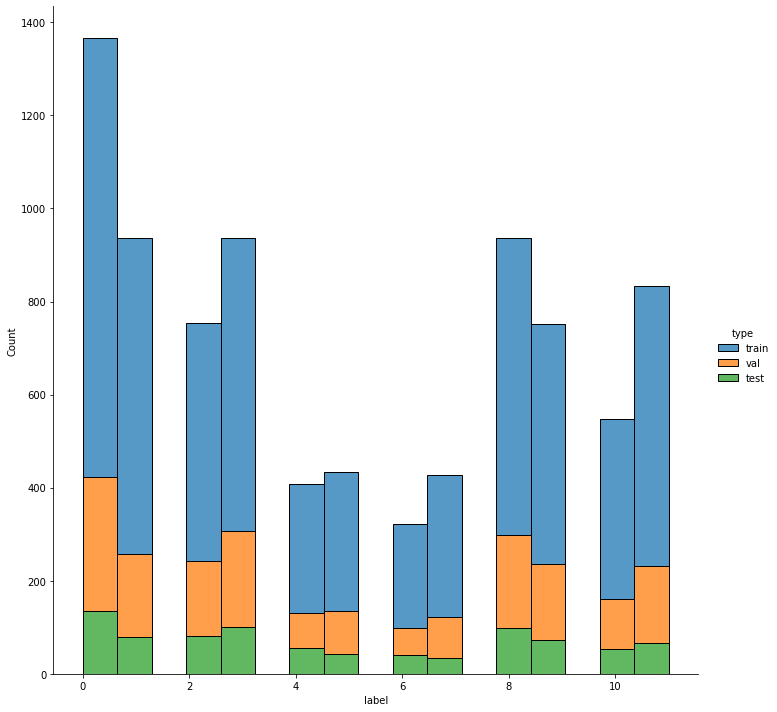

In [17]:
plot = sns.displot(data=df, x='label', kind='hist', hue='type', multiple="stack", height=10, aspect=1)
plot.savefig(f'{data_root}/labels_hist.jpg')